In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import os
import sys
sys.path.append('../scripts/')
sys.path.append('../scripts/helper_functions_cv/tensorflow_helpers/')
from save_masks import save_masks
import glob
from gpu_starter_mirror_strategy import start_gpus
from sklearn.model_selection import train_test_split
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1, 2, 3"
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
import tensorflow.keras.backend as K
from save_weights_every_epoch import CallbackForSavingModelWeights

Segmentation Models: using `keras` framework.


In [2]:
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [3]:
train_csv = pd.read_csv('../../data/train_ship_segmentations_v2.csv')

In [4]:
updated_train_csv = train_csv.groupby('ImageId')['EncodedPixels'].apply(list).reset_index()

In [5]:
updated_train_csv.head()

,ImageId,EncodedPixels
0,00003e153.jpg,[nan]
1,0001124c7.jpg,[nan]
2,000155de5.jpg,[264661 17 265429 33 266197 33 266965 33 26773...
3,000194a2d.jpg,[360486 1 361252 4 362019 5 362785 8 363552 10...
4,0001b1832.jpg,[nan]


In [6]:
updated_train_csv['updated_image_paths'] = updated_train_csv['ImageId'].apply(lambda x: '../../data/train_v2/' + x)

In [7]:
def get_mask_path(data):
    temp = data.split('.')[0]
    final = '../../data/masks/' + temp + '.png'
    return final

In [8]:
updated_train_csv['mask_paths'] = updated_train_csv['ImageId'].apply(get_mask_path)

In [9]:
updated_train_csv.head()

,ImageId,EncodedPixels,updated_image_paths,mask_paths
0,00003e153.jpg,[nan],../../data/train_v2/00003e153.jpg,../../data/masks/00003e153.png
1,0001124c7.jpg,[nan],../../data/train_v2/0001124c7.jpg,../../data/masks/0001124c7.png
2,000155de5.jpg,[264661 17 265429 33 266197 33 266965 33 26773...,../../data/train_v2/000155de5.jpg,../../data/masks/000155de5.png
3,000194a2d.jpg,[360486 1 361252 4 362019 5 362785 8 363552 10...,../../data/train_v2/000194a2d.jpg,../../data/masks/000194a2d.png
4,0001b1832.jpg,[nan],../../data/train_v2/0001b1832.jpg,../../data/masks/0001b1832.png


In [10]:
def check_paths(data):
    for path in data:
        if os.path.exists(path) == False:
            print(path)

In [11]:
check_paths(updated_train_csv['updated_image_paths'].values.tolist())

In [12]:
check_paths(updated_train_csv['mask_paths'].values.tolist())

In [13]:
def create_datasets(csv_file, test_size = 0.01):
    train, test = train_test_split(csv_file, test_size=test_size, random_state = 42)
    train, val = train_test_split(train, test_size=test_size, random_state = 42)
    return train, val, test

In [14]:
train, val, test = create_datasets(updated_train_csv)

* One file with issues should be removed currently in test set
* ../../data/train_v2/6384c3e78.jpg

In [15]:
test = test[test['updated_image_paths'] != '../../data/train_v2/6384c3e78.jpg']

In [16]:
print(f'Size of train set: {len(train)}')
print(f'Size of val set: {len(val)}')
print(f'Size of test set: {len(test)}')

Size of train set: 188723
Size of val set: 1907
Size of test set: 1925


In [17]:
def get_compile_model(encoder_name):
    with strategy.scope():
        model = sm.Unet(encoder_name, 
                        encoder_weights = None,
                        classes = 1,
                        activation = 'sigmoid')
        model.compile(
            'SGD',
            loss = sm.losses.bce_dice_loss,
            metrics = [sm.metrics.iou_score]
        )
    return model

In [18]:
def show_dataset_with_mask(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                         thumb_size*rows + (rows-1)))
    mosaic1 = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                         thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        try:
            img, mask = data
        except:
            img = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        mask = np.clip((mask.numpy().reshape(256, 256)) * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        mask = PIL.Image.fromarray(mask)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mask = mask.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                       iy*thumb_size + iy))
        mosaic1.paste(mask, (ix*thumb_size + ix, 
                       iy*thumb_size + iy))

    display(mosaic)
    display(mosaic1)

In [19]:
def get_train_imgs(img, mask, shape):
    img = tf.io.read_file(img)
    mask = tf.io.read_file(mask)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = shape)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, size = shape)
    img = img / 255.0
    mask = mask / 255.0
    return img, mask

In [20]:
def get_data(csv_file, repeat = True, prefetch = True, batch = True, shape = (256, 256), shuffle = True, batch_size = 32):
    imgs = csv_file['updated_image_paths'].values.tolist() 
    masks = csv_file['mask_paths'].values.tolist()
    shapes = [shape for x in range(len(masks))]
    tensor = tf.data.Dataset.from_tensor_slices((imgs, masks, shapes))
    tensor = tensor.cache()
    if repeat:
        tensor = tensor.repeat()
    if shuffle:
        tensor = tensor.shuffle(1024 * REPLICAS)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        tensor = tensor.with_options(opt)
    tensor = tensor.map(get_train_imgs, num_parallel_calls = AUTO)
    if batch:
        tensor = tensor.batch(batch_size * REPLICAS)
    if prefetch:
        tensor = tensor.prefetch(AUTO)
    return tensor

In [21]:
train_dataset = get_data(train)
val_dataset = get_data(val)
test_dataset = get_data(test)

/tmp/ipykernel_3403/4059159949.py:18: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
/tmp/ipykernel_3403/4059159949.py:19: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  mask = mask.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)


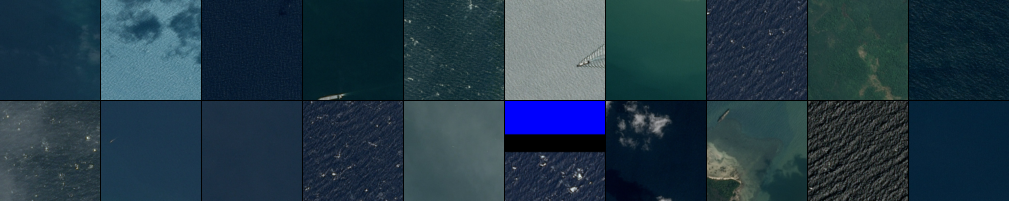

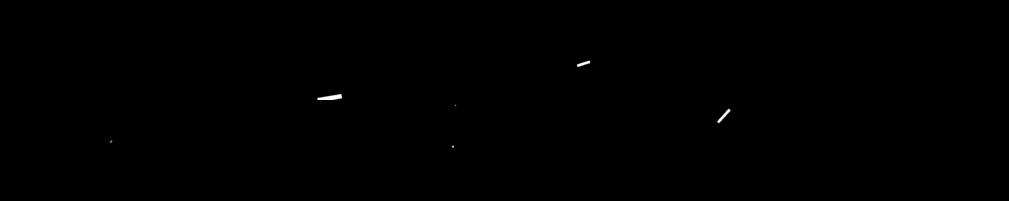

In [22]:
show_dataset_with_mask(100, 10, 2, train_dataset.unbatch().take(20))

/tmp/ipykernel_3403/4059159949.py:18: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
/tmp/ipykernel_3403/4059159949.py:19: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  mask = mask.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)


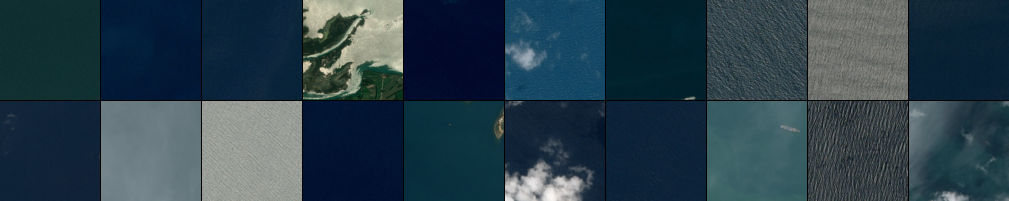

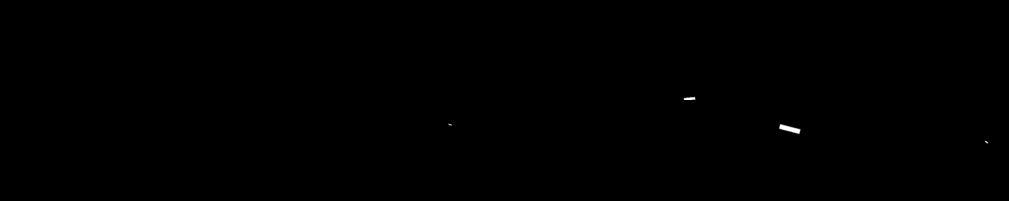

In [23]:
show_dataset_with_mask(100, 10, 2, val_dataset.unbatch().take(20))

/tmp/ipykernel_3403/4059159949.py:18: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
/tmp/ipykernel_3403/4059159949.py:19: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  mask = mask.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)


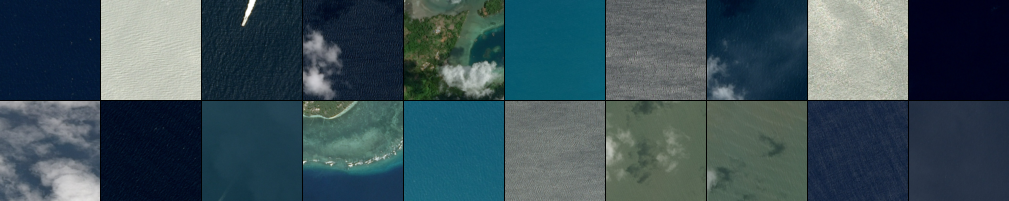

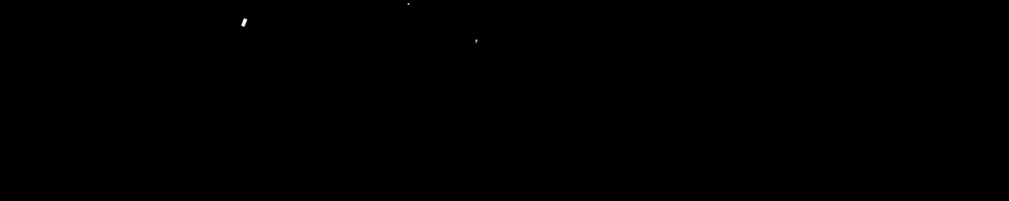

In [24]:
show_dataset_with_mask(100, 10, 2, test_dataset.unbatch().take(20))

In [32]:
K.clear_session()
log_dir = '../TB/segmentation/resnet50_baseline'
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir)
weights_path = '../../weights/resnet_50_baseline/'
weights_callback = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train)
batch_size = 32
val_dataset = get_data(val, repeat = False, shuffle = False)
with strategy.scope():
    model = get_compile_model('resnet50')
train_hist = model.fit(train_dataset, 
                       verbose=1, 
                       epochs=100, 
                       validation_data=val_dataset, 
                       steps_per_epoch=(len(train) / (batch_size * REPLICAS)),
                       callbacks=[weights_callback,
                                  tb_callback])

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 186 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 186 all-reduces with algorithm = nccl, num_packs = 1
1965/1965 [==============================] - 508s 237ms/step - loss: 0.7389 - iou_score: 0.1912 - val_loss: 0.4825 - val_iou_score: 0.3748
Epoch 2/100
1965/1965 [==============================] - 460s 234ms/step - loss: 0.4684 - iou_score: 0.3947 - val_loss: 0.4284 - val_iou_score: 0.4285
Epoch 3/100
1965/1965 [==============================] - 460s 234ms/step - loss: 0.4083 - iou_score: 0.4520 - val_loss: 0.3897 - val_iou_score: 0.4670
Epoch 4/100
1965/1965 [==============================] - 460s 234ms/step - loss: 0.3741 - iou_score: 0.4879 - val_loss: 0.3473 - val_iou_score: 0.5106
Epoch 5/100
1965/1965 [==============================] - 459s 234ms/step - loss: 0.3509 - iou_score: 0.5122 - val_loss: 0.3165 - val_iou_score: 0.5469
Epoch 6/100
1965/1965 [==============================] - 460s 234ms/ste

In [48]:
train_dataset = get_data(train, repeat = False, shuffle = False)
val_dataset = get_data(val, repeat = False, shuffle = False)
test_dataset = get_data(test, repeat = False, shuffle = False)

In [34]:
with strategy.scope():
    model = get_compile_model('resnet50')
    model.load_weights('../../weights/resnet_50_baseline/31.h5')

In [35]:
model.evaluate(train_dataset, verbose = 1)

1966/1966 [==============================] - 185s 89ms/step - loss: 0.1756 - iou_score: 0.7185


[0.17556066811084747, 0.7185354232788086]

In [25]:
model.evaluate(val_dataset, verbose = 1)

NameError: name 'model' is not defined

In [49]:
model.evaluate(test_dataset, verbose = 1)

21/21 [==============================] - 3s 106ms/step - loss: 0.2194 - iou_score: 0.6348


[0.2193918079137802, 0.634823739528656]

In [50]:
with strategy.scope():
    model = get_compile_model('resnet50')
    model.load_weights('../../weights/resnet_50_baseline/20.h5')

In [51]:
model.evaluate(train_dataset, verbose = 1)

1966/1966 [==============================] - 184s 89ms/step - loss: 0.2017 - iou_score: 0.6848


[0.2017395794391632, 0.6848083734512329]

In [52]:
model.evaluate(val_dataset, verbose = 1)

20/20 [==============================] - 2s 78ms/step - loss: 0.2256 - iou_score: 0.6536


[0.2255963385105133, 0.653634786605835]

In [53]:
model.evaluate(test_dataset, verbose = 1)

21/21 [==============================] - 2s 84ms/step - loss: 0.2380 - iou_score: 0.6121


[0.23800191283226013, 0.6120818853378296]

* So far resent with epoch number 20 is best.

In [27]:
K.clear_session()
log_dir = '../TB/segmentation/incep_baseline'
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir)
weights_path = '../../weights/incep_baseline/'
weights_callback = CallbackForSavingModelWeights(weights_path)
batch_size = 64
train_dataset = get_data(train, batch_size=batch_size)
val_dataset = get_data(val, repeat = False, shuffle = False, batch_size=batch_size)
with strategy.scope():
    model = get_compile_model('inceptionv3')
train_hist = model.fit(train_dataset, 
                       verbose=1, 
                       epochs=100, 
                       validation_data=val_dataset, 
                       steps_per_epoch=(len(train) / (batch_size * REPLICAS)),
                       callbacks=[weights_callback,
                                  tb_callback])

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 220 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 220 all-reduces with algorithm = nccl, num_packs = 1
